Reflecting on 2017, I decided to return to my [most popular blog topic](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/) (at least by the number of emails I get). Last time, I built a crude statistical model to predict the result of football matches. I even presented a webinar on the subject [here](https://www.brighttalk.com/webcast/9059/282915/predicting-football-results-with-statistical-modelling) (it's free to sign up). During the presentation, I described a coefficient in the model that accounts for the fact that the home team tends to score more goals than the away team. This is called the home advantage or home field advantage and can [probably be explained](https://www.theguardian.com/sport/2008/feb/03/features.sportmonthly16) by a combination of physcological (e.g. familiarity with surroundings) and physical factors (e.g. travel). [It occurs in various sports](https://www.researchgate.net/publication/7671541_Long-term_trends_in_home_advantage_in_professional_team_sports_in_North_America_and_England_1876-2003f), including American football, baseball, basketball and soccer. Sticking to soccer/football, I mentioned in my talk how it would be interesting to see how this effect varies around the world. In which countries do the home teams enjoy the greatest advantage?

We're going to use the [same statistcal model as last time](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/), so there won't be any new statistical features developed in this post. Instead, it will focus on retrieving the appropriate goals data for even the most obscure leagues in the world (yes, even the Irish Premier Division) and then interactively visualising the results with D3. The full code can be found in the [accompanying Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2018-01-10-home-advantage-in-football-leagues-around-the-world.ipynb).

## Calculating Home Field Advantage

The first consideration should probably be how to calculate home advantage. The [traditional approach](https://en.wikipedia.org/wiki/Home_advantage#Measuring_of_home-field_advantage) is to look at team matchups and check whether teams achieved better, equal or worse results at home than away. For example, let's imagine Chlesea beat Arsenal 2-0 at home and drew 1-1 away. That would be recored as a better home result (+2 goals versus 0). This process is repeated for every opponent and so [you can actually construct a trinomial distribution and test whether there was a statistically significant home field effect](https://www.researchgate.net/publication/318588534_Home_Team_Advantage_in_English_Premier_League). This works for balanced leagues, where team play each other an equal number of times home and away. While this holds for Europe's most famous leagues (e.g. EPL, La Liga), there are various leagues where teams play each other threes times (e.g. Ireland, Montenegro, Tajikistan aka The Big Leagues) or even just once (e.g Libya and to a lesser extent MLS (balanced for teams within the same conference)). There's also issues with postponements and abandonments rendering some leagues slightly unbalanced (e.g. Sri Lanka). For those reasons, we'll opt for a different (though not necessarily better) approach.

In the [previous post](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/), we built a model for the EPL 2016/17 season, using the number of goals scored in the past to predict future results. Looking at the model coefficients again, you see the `home` coefficient has a value of approximately 0.3. By taking the exponent of this value ($exp^{0.3}=1.35$), it tells us that the home team are generally 1.35 times more likely to score than the away team. In case you don't recall, the model accounts for team strength/weakness by including coefficients for each team (e.g  0.07890 and -0.96194 for Chelsea and Sunderland, respectively). 

Let's see how this value compares with the lower divisions in England over the past 10 years. We'll pull the data from [football-data.co.uk](football-data.co.uk), which can loaded in directly using the url link for each csv file. First, we'll design a function that will take a dataframe of match results as an input and return the home field advantage (plus confidence interval limits) for that league.

In [11]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

def get_home_team_advantage(goals_df, pval=0.05):
    
    # extract relevant columns
    model_goals_df = goals_df[['HomeTeam','AwayTeam','FTHG','FTAG']]
    # rename goal columns
    model_goals_df = model_goals_df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})

    # reformat dataframe for the model
    goal_model_data = pd.concat([model_goals_df[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
                columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
               model_goals_df[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
                columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    # build poisson model
    poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    # output model parameters
    poisson_model.summary()
    
    return np.concatenate((np.array([poisson_model.params['home']]), 
                    poisson_model.conf_int(alpha=pval).values[-1]))

/home/david/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


I've essentially combined various parts of the previous post into one convenient function. If it looks a little strange, then I suggest you consult the original post. Okay, we're ready to start calculating some home advantage scores.

In [12]:
# home field advantage for EPL 2016/17 season
get_home_team_advantage(pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv"))

array([ 0.2838454,  0.16246  ,  0.4052308])

It's as easy as that. Feed a url from [football-data.co.uk](http://www.football-data.co.uk/data.php) into the function and it'll quickly tell you the statistical advantage enjoyed by home teams in that league. Note that the latter two values repesent the left and right limit of the 95% confidence interval around the mean value. The first value in the array is actually just the log of the number of goals scored by the home team divided by the total number of away goals.

In [13]:
temp_goals_df = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
[np.exp(get_home_team_advantage(temp_goals_df)[0]),
 np.sum(temp_goals_df['FTHG'])/float(np.sum(temp_goals_df['FTAG']))]

[1.3282275711159723, 1.3282275711159737]

The goals ratio calculation is obviously much simpler and definitely more intuitive. But it doesn't allow me to reference [my previous post](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/) as much ([link](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/) [link](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/) [link](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)) and it fails to provide any uncertainty around the headline figure. Let's plot the home advantage figure for the top 5 divisions of the English league pyramid for since 2005. You can remove those hugely informative confidence interval bars by unticking the checkbox.

In [14]:
division_results = []
for division in range(5):
    year_results = []
    for year in range(2005,2017):
        if division==4:
            division_string = 'C'
        else:
            division_string = str(division)
        url = "http://www.football-data.co.uk/mmz4281/"+str(year)[-2:]+str(year+1)[-2:]+"/E"+division_string+".csv"
        print(url)
        year_results.append(np.concatenate((np.array([year, division]), get_home_team_advantage(pd.read_csv(url)))))
    division_results.append(np.vstack(year_results))

http://www.football-data.co.uk/mmz4281/0506/E0.csv
http://www.football-data.co.uk/mmz4281/0607/E0.csv
http://www.football-data.co.uk/mmz4281/0708/E0.csv
http://www.football-data.co.uk/mmz4281/0809/E0.csv
http://www.football-data.co.uk/mmz4281/0910/E0.csv
http://www.football-data.co.uk/mmz4281/1011/E0.csv
http://www.football-data.co.uk/mmz4281/1112/E0.csv
http://www.football-data.co.uk/mmz4281/1213/E0.csv
http://www.football-data.co.uk/mmz4281/1314/E0.csv
http://www.football-data.co.uk/mmz4281/1415/E0.csv
http://www.football-data.co.uk/mmz4281/1516/E0.csv
http://www.football-data.co.uk/mmz4281/1617/E0.csv
http://www.football-data.co.uk/mmz4281/0506/E1.csv
http://www.football-data.co.uk/mmz4281/0607/E1.csv
http://www.football-data.co.uk/mmz4281/0708/E1.csv
http://www.football-data.co.uk/mmz4281/0809/E1.csv
http://www.football-data.co.uk/mmz4281/0910/E1.csv
http://www.football-data.co.uk/mmz4281/1011/E1.csv
http://www.football-data.co.uk/mmz4281/1112/E1.csv
http://www.football-data.co.uk/

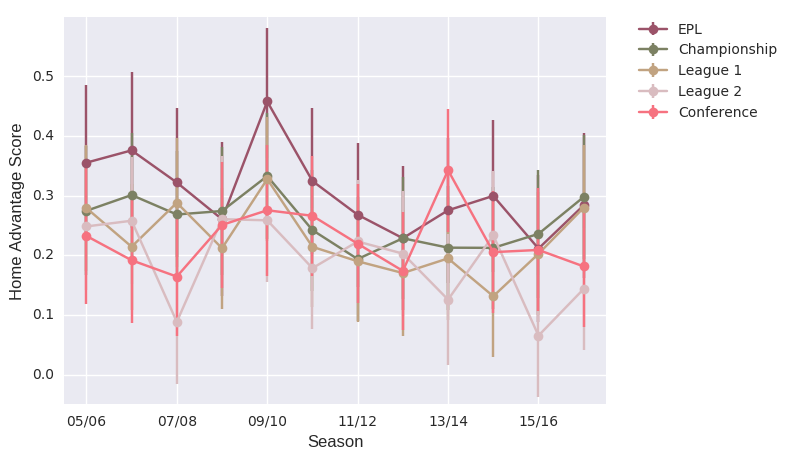

<function __main__.plot_func>

In [15]:
from ipywidgets import interact, Checkbox

def plot_func(freq):
    fig, ax1 = plt.subplots(1, 1,figsize=(7, 5))
    for div, (div_name, div_col) in enumerate(zip(['EPL', 'Championship', 'League 1', 'League 2', 'Conference'],
                               ["#9b5369", "#7c8163", "#c1a381", "#d9bcc0", "#F67280"])):
        if freq:
            ax1.errorbar(division_results[div][:,0], division_results[div][:,2],
                         yerr= (division_results[div][:,4] - division_results[div][:,2]),
                          linestyle='-', marker='o',label=div_name, color = div_col)
        else:
            ax1.plot(division_results[div][:,0], division_results[div][:,2],
                          linestyle='-', marker='o',label=div_name, color = div_col)
    #[str(int(item.get_text())+1)[-2:] for item in ax1.get_xticklabels()]
    ax1.set_xticks([2005, 2007, 2009, 2011, 2013, 2015])
    ax1.set_xlabel('Season', fontsize=12)
    ax1.set_ylabel('Home Advantage Score', fontsize=12)
    ax1.set_ylim([-0.05, 0.6])
    ax1.set_xlim([2004.5, 2016.5])
    ax1.set_xticklabels(['05/06', '07/08', '09/10', '11/12', '13/14', '15/16'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
interact(plot_func, freq = Checkbox(
    value=True,
    description='Error Bars',
    disabled=False))

It's probably more apparent without those hugely informative confidence interval bars, but it seems that the home advantage score decreases slightly as you move down the pyramid ([analysis by Sky Sports produced something similar](http://www.skysports.com/football/news/11096/10955089/sky-sports-bust-common-football-myths-home-advantage)). This might make sense for two reasons. Firstly, bigger teams generally have larger stadiums and more supporters, which could strengthen the home field advantage. Secondly, as you go down the leagues, I suspect the quality gap between teams narrows. Taking it to an extreme, when I used to play Sunday league football, it didn't really matter where we played... we still lost. In that sense, one must be careful comparing the home advantage between leagues, as it will be affected by the relative team strengths within those leagues. For example, a league with a very dominant team (or teams) will record a lower home advantage score, as that dominant team will score goals home and away with little difference (Man Utd would probably beat Cork City 6-0 at Old Trafford and Turners Cross!).

Having warned about the dangers of comparing different leagues with this approach, let's now compare the top five leagues in Europe over the same time period as before.

In [16]:
country_results = []
for country in ['E0', 'SP1', 'I1', 'D1', 'F1']:
    year_results = []
    for year in range(2005,2017):
        url = "http://www.football-data.co.uk/mmz4281/"+str(year)[-2:]+str(year+1)[-2:]+ "/" + country +".csv"
        print(url)
        year_results.append(np.concatenate((np.array([year, division]), 
                                            get_home_team_advantage(pd.read_csv(url)))))
    country_results.append(np.vstack(year_results))

http://www.football-data.co.uk/mmz4281/0506/E0.csv
http://www.football-data.co.uk/mmz4281/0607/E0.csv
http://www.football-data.co.uk/mmz4281/0708/E0.csv
http://www.football-data.co.uk/mmz4281/0809/E0.csv
http://www.football-data.co.uk/mmz4281/0910/E0.csv
http://www.football-data.co.uk/mmz4281/1011/E0.csv
http://www.football-data.co.uk/mmz4281/1112/E0.csv
http://www.football-data.co.uk/mmz4281/1213/E0.csv
http://www.football-data.co.uk/mmz4281/1314/E0.csv
http://www.football-data.co.uk/mmz4281/1415/E0.csv
http://www.football-data.co.uk/mmz4281/1516/E0.csv
http://www.football-data.co.uk/mmz4281/1617/E0.csv
http://www.football-data.co.uk/mmz4281/0506/SP1.csv
http://www.football-data.co.uk/mmz4281/0607/SP1.csv
http://www.football-data.co.uk/mmz4281/0708/SP1.csv
http://www.football-data.co.uk/mmz4281/0809/SP1.csv
http://www.football-data.co.uk/mmz4281/0910/SP1.csv
http://www.football-data.co.uk/mmz4281/1011/SP1.csv
http://www.football-data.co.uk/mmz4281/1112/SP1.csv
http://www.football-data

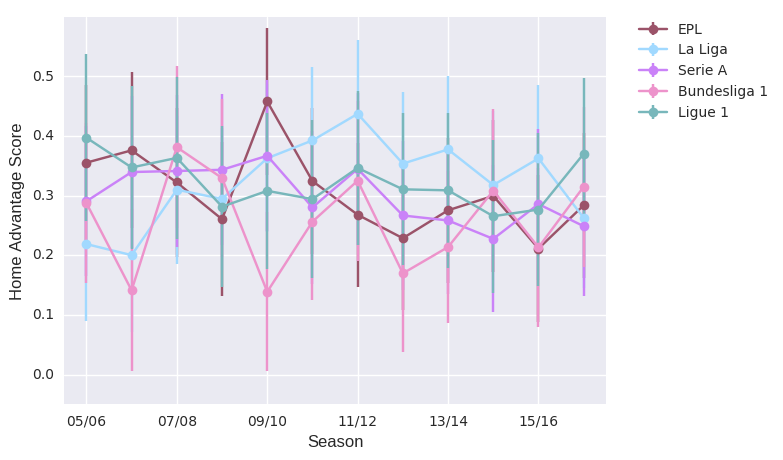

In [17]:
def plot_func(freq):
    fig, ax1 = plt.subplots(1, 1,figsize=(7, 5))
    for div, (div_name, div_col) in enumerate(zip(['EPL', 'La Liga', 'Serie A', 'Bundesliga 1', 'Ligue 1'],
                                   ["#9b5369", "#A1D9FF", "#CA82F8", "#ED93CB", "#78B7BB"])):
        if freq:
            ax1.errorbar(country_results[div][:,0], country_results[div][:,2],
                         yerr= (country_results[div][:,4] - country_results[div][:,2]),
                          linestyle='-', marker='o',label=div_name, color = div_col)
        else:
            ax1.plot(country_results[div][:,0], country_results[div][:,2],
                          linestyle='-', marker='o',label=div_name, color = div_col)

    ax1.set_xticks([2005, 2007, 2009, 2011, 2013, 2015])
    ax1.set_ylim([-0.05, 0.6])
    ax1.set_xlim([2004.5, 2016.5])
    ax1.set_xlabel('Season', fontsize=12)
    ax1.set_ylabel('Home Advantage Score', fontsize=12)
    ax1.set_xticklabels(['05/06', '07/08', '09/10', '11/12', '13/14', '15/16'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
interact(plot_func, freq = Checkbox(
    value=True,
    description='Error Bars',
    disabled=False))

Honestly, there's not much going on there. With the poissble exception of the Spanish La Liga since 2010, the home field advantage enjoyed by the teams in each league is broadly similar (and that's before we bring in the idea of confidence intervals and hypothesis testing).

## Home Advantage Around the World

To find more interesting contrasts, we must venture to crappier and more corrupt leagues. My hunch is that home advantage would be negligible in countries where the overall quality (team, infastructure, etc.) is very low. And by low, I mean leagues worse than the Irish Premier Division (yes, they exist). Unfortunately, the historical results for such leagues are not available on football-data.co.uk. Instead, we'll scrape the data off [betexplorer](http://www.betexplorer.com). I'm extremely impressed by the breadth of this site. You can even retrieve past results for the French overseas department of [Réunion](http://www.betexplorer.com/soccer/reunion/regionale-1/results/). Fun fact: [Dimtri Payet](https://en.wikipedia.org/wiki/Dimitri_Payet#Early_career) spent the 2004 season at AS Excelsior of the Réunion Premier League.

We'll use [Scrapy](https://scrapy.org/) to pull the appropriate information off the website. If you've never used Scrapy before, then you should check out [this post](https://dashee87.github.io/data%20science/python/charting-the-rise-of-song-collaborations-with-scrapy-and-pandas/). I won't spend too long on this part, but you can find the full code on [here](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2018-01-10-home-advantage-in-football-leagues-around-the-world.ipynb).

In [1]:
import scrapy
import re # for text parsing
import logging
import pandas as pd

class FootballSpider(scrapy.Spider):
    name = 'footballSpider'
    # page to scrape
    start_urls = pd.read_csv(
        'https://raw.githubusercontent.com/dashee87/blogScripts/master/files/league_links.csv')['link'].tolist() + \
    pd.read_csv("league_links_.csv")['link2'].dropna(axis=0, how='all').tolist()
    # if you want to impose a delay between sucessive scrapes
#   download_delay = 1.0 

    def parse(self, response):
        self.logger.info('Scraping page: %s', response.url)
        country_league = response.css('.list-breadcrumb__item__in::text').extract()
        
        for num, (hometeam, awayteam, match_result, date) in \
            enumerate(zip(response.css('.in-match span:nth-child(1)'), 
                                 response.css('.in-match span:nth-child(2)'),
                                 response.css('td.h-text-center'),
                                 response.css('.h-text-no-wrap::text').extract())):
            yield {'country':country_league[2], 'league': country_league[3],
                   'HomeTeam': hometeam.css('::text').extract_first(), 
                   'AwayTeam':awayteam.css('::text').extract_first(), 
                   'FTHG':  re.sub(':.*', '', match_result.css('::text').extract_first()), 
                   'FTAG':  re.sub('.*:', '', match_result.css('::text').extract_first()),
                   'awarded': ' ' in match_result.css('::text').extract_first() or
                   'AWA.' in match_result.css('::text').extract_first(),
                   'date':date}

In [2]:
from scrapy.crawler import CrawlerProcess

process = CrawlerProcess({
'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)',
'FEED_FORMAT': 'json',
'FEED_URI': 'all_league_goals_.json'
})

# minimising the information presented on the scrapy log
logging.getLogger('scrapy').setLevel(logging.WARNING)
process.crawl(FootballSpider)
process.start()

2018-01-09 15:26:24 [scrapy.utils.log] INFO: Scrapy 1.4.0 started (bot: scrapybot)
2018-01-09 15:26:24 [scrapy.utils.log] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'all_league_goals_.json', 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
2018-01-09 15:26:25 [footballSpider] INFO: Scraping page: http://www.betexplorer.com/soccer/albania/super-league-2016-2017/results/
2018-01-09 15:26:25 [footballSpider] INFO: Scraping page: http://www.betexplorer.com/soccer/andorra/primera-divisio-2016-2017/results/?stage=dp9brpEB


You don't actually need to run your own spider, as I've shared the output to [my GitHub account](https://github.com/dashee87/blogScripts/tree/master/files). We can import the json file in directly using pandas.

In [22]:
all_league_goals = pd.read_json(
    "https://raw.githubusercontent.com/dashee87/blogScripts/master/files/all_league_goals.json")
# reorder the columns to it a bit more logical
all_league_goals = all_league_goals[['country', 'league', 'date', 'HomeTeam', 
                                     'AwayTeam', 'FTHG', 'FTAG', 'awarded']]
all_league_goals.head()

,country,league,date,HomeTeam,AwayTeam,FTHG,FTAG,awarded
0,Albania,Super League 2016/2017,2017-05-27,Korabi Peshkopi,Flamurtari,0,3,False
1,Albania,Super League 2016/2017,2017-05-27,Laci,Teuta,2,1,False
2,Albania,Super League 2016/2017,2017-05-27,Luftetari Gjirokastra,Kukesi,1,0,False
3,Albania,Super League 2016/2017,2017-05-27,Skenderbeu,Partizani,2,2,False
4,Albania,Super League 2016/2017,2017-05-27,Vllaznia,KF Tirana,0,0,False


Hopefully, that's all relatively clear. You'll notice that it's very similar to the format used by football-data, which means that we can feed this dataframe into the `get_home_team_advantage` function. Sometimes, matches are awarded due to one team fielding an ineligible player or crowd trouble. We should probably exclude such matches from the home field advantage calculations.

In [25]:
# little bit of data cleansing to remove fixtures that were abandoned/awarded/postponed
all_league_goals = all_league_goals[~all_league_goals['awarded']]
all_league_goals = all_league_goals[all_league_goals['FTAG']!='POSTP.']
all_league_goals = all_league_goals[all_league_goals['FTAG']!='CAN.']
all_league_goals[['FTAG', 'FTHG']] = all_league_goals[['FTAG', 'FTHG']].astype(int)

We're ready to put it all together. I'll omit the code (though it can be found here), but we'll loop through each country and league combination (just in case you decide to include multiple leagues from the same country) and calculate the home advantage score, plus its confidence limits as well as some other information for each league (number of teams, average number of goals in each match). I've converted the pandas output to a [datatables](https://datatables.net/) table that you can interactively filter and sort.

In [27]:
home_advantage_country = pd.DataFrame(all_league_goals.assign(match_goals = all_league_goals['FTHG'] +  
                                      all_league_goals['FTHG']).groupby(['country','league']).agg(
        {'HomeTeam':['size','nunique'], 'match_goals':'mean'}).to_records())
home_advantage_country.columns = ['country', 'league', 'num_games', 'num_teams', 'avg_goals']
temp_set = []
for i in range(home_advantage_country.shape[0]):
    temp_set.append(get_home_team_advantage(all_league_goals[(
                    all_league_goals['country']==home_advantage_country['country'][i]) & (
                all_league_goals['league']==home_advantage_country['league'][i])]))
temp_set = pd.DataFrame(temp_set,columns= ['home_advantage_score', 'left_tail', 'right_tail'])
home_advantage_country = pd.concat([home_advantage_country, temp_set], axis=1).sort_values('home_advantage_score', 
                                            ascending=False).reset_index(drop=True)
home_advantage_country.index = home_advantage_country.index + 1
# if you want display more/less rows than the default option
pd.options.display.max_rows = 40
home_advantage_country.assign(avg_goals= pd.Series.round(home_advantage_country['avg_goals'], 3),
                             home_advantage_score= pd.Series.round(home_advantage_country['home_advantage_score'], 3),
                             left_tail= pd.Series.round(home_advantage_country['left_tail'], 3),
                             right_tail= pd.Series.round(home_advantage_country['right_tail'], 3))

,country,league,num_games,num_teams,avg_goals,home_advantage_score,left_tail,right_tail
1,Nigeria,Premier League 2017,379,20,3.087,1.195,1.027,1.363
2,Haiti,Championnat National 2017,237,16,2.329,0.741,0.533,0.949
3,Algeria,Ligue 1 2016/2017,238,16,2.790,0.698,0.512,0.884
4,Ghana,Premier League 2017,238,16,2.924,0.676,0.494,0.857
5,Bolivia,Liga de Futbol Prof 2016/2017,132,12,4.470,0.624,0.431,0.818
6,Guatemala,Liga Nacional 2016/2017,264,12,2.803,0.620,0.448,0.792
7,Benin,Championnat National 2017,162,19,2.272,0.571,0.330,0.811
8,USA,MLS 2017,374,22,3.749,0.538,0.416,0.660
9,Peru,Primera Division 2017,238,16,3.361,0.520,0.359,0.680
10,Indonesia,Liga 1 2017,304,18,3.618,0.515,0.378,0.651


Focusing on the `home_advantage_score` column, teams in Nigeria by far enjoy the greatest benefit from playing at home (score = 1.195). In other words, home teams scored 3.3 (= $e^{1.195}$) times more goals than their opponents. This isn't new information and [can be attributed to a combination of corruption (e.g. bribing referees) and violent fans](https://www.theguardian.com/football/blog/2013/oct/29/nigeria-toughest-league-win-away). In fact, my motivation for this post was to identify more football corruption hotspots. Alas, when it comes to home turf invincibility, it seems Nigeria are the World Cup winners.

Fifteen leagues have a negative `home_advantage_score`, meaning that visiting teams actually scored more goals than their hosts- though none was statistically significant. By some distance, the Maldives records the most negative score. Luckily, I've twice researched this beautiful archipelago and I'm aware that [all matches in the Dhiveli Premier League are played at the national stadium in Malé](https://en.wikipedia.org/wiki/Dhivehi_Premier_League#Stadiums) (much like the [Gibraltar Premier League](https://en.wikipedia.org/wiki/2017%E2%80%9318_Gibraltar_Premier_Division#Teams)). So it would make sense that there's no particular advantage gained by the home team. Libya is another interesting example. Owing to security issues, [all matches in the Libyan Premier League are played in neutral venues with no spectators present](https://en.wikipedia.org/wiki/2017%E2%80%9318_Libyan_Premier_League#Stadiums). Quite fittingly, it returned a home advantage score just off zero. Generally speaking, the leagues with near zero home advantage come from small countries (minimal inconvenience for travelling teams) with a small number of teams and they tend to share stadiums.

If you sort the `avg_goals` column, you'll see that Bolivia is the place to be for goals (average = 4.47). But rather than sifting through that table or explaining the results with words, the most intuitive way to illustrate this type of data is with a map of world. This might also help to clarify whether there's any geographical influence on the home advantage effect. Again, I won't go into the details (an appendix can be found in the [Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2018-01-10-home-advantage-in-football-leagues-around-the-world.ipynb)), but I built a map using the JavaScript library, D3. And by built I mean I adapted the code from [this post](http://bl.ocks.org/micahstubbs/8e15870eb432a21f0bc4d3d527b2d14f) and [this post](https://bl.ocks.org/mbostock/2206590). Though a little outdated now, I found [this post](https://bost.ocks.org/mike/map/) quite useful too. Finally, I think [this post](https://codepen.io/sassquad/post/rough-guide-to-building-uk-election-maps-for-d3-js) shows off quite well what you can do with maps using D3.

And here it is! The country colour represents its `home_advantage_score`. You can zoom in and out and hover over a country to reveal a nice informative overlay; use the radio buttons to switch between home advantage and goals scored. I recommend viewing it on desktop (mobile's a bit jumpy) and on Chrome (sometimes have security issues with Firefox).

![title](https://github.com/dashee87/dashee87.github.io/raw/master/images/world_map_football.png)

It's not scientifically rigorous (not in academia any more, baby!), but there's evidence for some geographical trends. For example, it appears that home advantage is stronger in Africa and South America compared to Western and Central Europe, with the unstable warzones of Libya, Somalia and Paraguay (?) being notable exceptions. As for average goals, Europe boasts stonger colours compared to Africa, though South East Asia seems to be the global hotspot for goals. North America is also quite dark, but you can debate whether Canada should be coloured grey, as the best Canadian teams belong to the American soccer system.

## Conclusion

Using a [previously described model](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/) and some JavaScript, this post explored the so called home advantage in football leagues all over the world (including Réunion). I  don't think it uncovered anything particularly amazing: different leagues have different properties and don't bet on the away team in the Nigerian league. You can play around with the Python code [here](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2018-01-10-home-advantage-in-football-leagues-around-the-world.ipynb). Thanks for reading!

# Appendix

This section is intended more than anything else as a reminder to myself if I ever want to build a map with D3 again.

We need to write the country league data to a csv that will then be loaded into the d3 map. To improve readability, the values are rounded to 3 decimal places. The country outlines in the map (see below) will be coloured according to their average goals or home advantage score. Rather than matching on country name (which can be fickle- is it Democratic Republic of Congo or DR Congo or even Congo-Kinshasa?), we'll append a column for the [country ISO 3166-1 alpha-3 code](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3). I'd like to say I scraped some page here, but it was mostly a manual job. After creating some new columns for the column ranking, the file is written to the local directory (alternatively, you can view it [here](https://github.com/dashee87/dashee87.github.io/blob/master/_includes/home_advantage.csv)).

In [227]:
home_advantage_country.assign(avg_goals= pd.Series.round(home_advantage_country['avg_goals'], 3),
                             home_advantage_score= pd.Series.round(home_advantage_country['home_advantage_score'], 3),
                             left_tail= pd.Series.round(home_advantage_country['left_tail'], 3),
                             right_tail= pd.Series.round(home_advantage_country['right_tail'], 3)).merge(
    pd.read_csv("https://raw.githubusercontent.com/dashee87/blogScripts/master/files/league_links.csv", 
                usecols = ['country', 'countryCode'], encoding='latin-1'), 
    on="country", how="inner").reset_index().rename(columns={"index": "home_adv_rank"}).sort_values(
    'avg_goals', ascending=False).reset_index(drop=True).reset_index().rename(columns={"index": "avg_goals_rank"}).to_csv(
    "home_advantage.csv", encoding='utf-8', index=False)

#### Shapefiles and TopoJSON

Generating the world map required a little bit of command line, python and a whole lot of JavaScript (specifically D3). The command line was used to convert the shapefiles into geojson files (see [ogr2ogr](http://www.gdal.org/ogr2ogr.html) and finally into the [topojson format](https://medium.com/@mbostock/command-line-cartography-part-3-1158e4c55a1e). The main reason for the last step is that it drastically reduces the file size, which should improve its onsite loading (though it could also affect the quality of the map). 

My particular map was complicated by the fact that some sovereign states are composed of several countries that organise their own national competitions. If that sounds weird, think of the United Kingdom. It's a member of the UN and a sovereign state in its own right (despite what Brexiteers may say). But there's no UK (or British) Premier League; there's the English/Welsh/Scottish/Northern Irish Premier League/Premiership. Similarly, Reunion is part of France but has its own football league. Then again, the Basque country is recognised as a nation within Spain, but has no internationally recognised national league. In summary, it's complicated.

Political realities aside, we need to get the geojson file for all of the countries in the world (see all.geojson available [here](https://github.com/AshKyd/geojson-regions/tree/master/countries/10m)). We must remove the United Kingdom, France and a few others. To reduce the file size, I also removed some country information that wasn't relevant for my purposes (population, GDP, etc.). The geojson files for England, Scotland, Reunion, etc. were a little harder to track down. The shapefile containing those country subdivisions can be downloaded [here](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/), which can be converted into geojson files with [ogr2ogr](http://www.gdal.org/ogr2ogr.html). Unfortunately, that file contains various subdivisions that don't correspond to actual football leagues (e.g. Belgium is split into the Flemish and Walloon regions). That means we need append the subdivisions we do want to higher level geojson file, which I did my manipulating the two json files in Python.

In [229]:
import json

all_nations = json.load(open('all.geojson'))
# command line: ogr2ogr -f GEOJson -where "ADM0_A3 IN ('GBR', 'FRA','NLD', 'USA')" \
# football_subdivisions.json ne_10m_admin_0_map_units.shp
subdivisions = json.load(open('football_subdivisions.json'))

In [210]:
all_nations_tidy = {}
all_nations_tidy['type']= all_nations['type']
all_nations_tidy['crs'] = all_nations['crs']
all_nations_tidy['features'] = []

for country_features in all_nations['features']:
    # skip UK, France, US, Netherlands and Antartica
    if (country_features['properties']['ADM0_A3'] in ['GBR', 'FRA', 'USA', 'NLD', 'ATA'] or 
    # skip minor islands and territories with populations less than 1000
    country_features['properties']['POP_EST']<1000) and \
    # don't want to exclude Western Sahara
    country_features['properties']['NAME_LONG'] != 'Western Sahara':
        continue
    if True:
        all_nations_tidy['features'].append({'properties': {'country': country_features['properties']['NAME_LONG'],
                                   'countryCode': country_features['properties']['ADM0_A3']},
                                   'geometry': country_features['geometry']})
    
for subdiv_features in subdivisions['features']:
    all_nations_tidy['features'].append({'properties': {'country': subdiv_features['properties']['NAME_LONG'],
                               'countryCode': subdiv_features['properties']['BRK_A3']},
                               'geometry': subdiv_features['geometry']})

with open('countries.json', 'w') as outfile:
    json.dump(all_nations_tidy, outfile)

We now have a json file containing all the subdivisions and country outlines we want, but it's quite large (>20MB), which you may not want to load on the page. The good news is that we can convert the file to an alternative cartographical format called topojson. It should preserve most of the information (i.e the borders) and reduces the file size significantly by creating efficiencies and removing redundancies (e.g. shared borders). If you've installed [topojson](https://medium.com/@mbostock/command-line-cartography-part-3-1158e4c55a1e), then it's as simple as running this command `geo2topo -q 1e4  countries.json>world_topo.json`.